This is the extension of the ANN. Instead of using single point spectra, we are using the entire EEM at 51 excitations and 51 emissions and building a CNN. (x,y) = (excitation,emission) in nanometers.

Load modules and read the csv.

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy as sp
import matplotlib.pyplot as plt

df=pd.read_csv(r"C:\Users\maiaz\Desktop\AmBD1 (2).csv",header=0)

This crops whatever EEM is uploaded into a an (mxm) matrix with the number of rows and columns being the number excitation wavelengths. You are able to choose which emission wavelength you want to start at depending on where you expect the fluorescent peaks to be. 

In [10]:
def croprange(X,a):
    '''
    inputs: 
    X --> EEM as a dataframe
    a --> The desired 1st emission wavelength
    output:
    X, cropped from a to len(number of columns in X), aka: as a mxm df
    '''
    ex_range = len(X.columns[1:])
    rows=X.iloc[:,0]
    row_ind=X.index[rows==a].values.astype(str).astype(int)
    row_ind=row_ind[0]
    #315 --> 565
    X=X.loc[row_ind:row_ind+ex_range,:]
    X=X.reset_index(drop=True)
    return(X)

This pads the EEM into a square matrix if you don't want to cut any of the existing matrix off (ie: the situation in which you have peaks at each end of your EEM). 

In [11]:
def padsquare(X):
    """
     inputs: 
    X --> EEM as a dataframe
    output:
    X, padded to the mxm matrix where m is the number of excitation wavelengths
    """
    columns = len(X.columns[1:].values)
    rows=len(X.iloc[:,0].values)
    if rows>columns:
        dif=rows-columns-1
        pad=pd.DataFrame(0,index=range(rows),columns=range(dif))
        X=pd.concat([X,pad],axis=1)
        return(X)
    if columns>rows:
        dif=columns-rows-1
        pad=pd.DataFrame(0,index=range(dif),columns=range(columns))
        X=pd.concat([X,pad])
        return(X)

Two helper functions. One finds the wavelength of the peak Raman scatter and returns that as a list. The other is used if the user wants to interpolate.

In [12]:
def findraman(X,order):
    '''
    inputs: 
    X --> EEM as a dataframe
    order --> 1st or 2nd order raman scatter
    output: raman_peak_list = an int list of the emission wavelengths
            where the raman scatter peaks live
    '''
    raman_peak_list=[]
    columns = X.columns[1:]
    for ex in columns:
        ex=int(ex)
        raman_peak=(-order*ex)/(.00036*ex-1)
        raman_peak_list.append(round(raman_peak))
    return(raman_peak_list)

def interpolate(X):
    columns=X.columns[1:]
    for col in columns:
        X[col].interpolate(method='polynomial', order=2, inplace=True)
        X[col].fillna(method='bfill', inplace=True)
        X[col].fillna(method='ffill', inplace=True)
    return(X)


The function is intended to remove 1st and 2nd order Raman and Rayleigh scattering and interpolate the removed wavelengths. You are able to adjust the number of nanometers you want removed on either side of the peak Raman scatter as well as interpolate the removed values.

In [13]:
def unscatter(X,kind,order,width,inter):
    '''
    inputs: 
    X --> EEM as a dataframe
    kind --> 0: raman or 1: raleigh depending on scatter
    order --> 1 or 2, 1st or 2nd order outputs: EEM with scatter specified removed
    width=nm desired to remove on either side of the raman scatter peak
    inter=True/False interpolate the missing values or not
    
    outputs:
    X with scatter taken out at desired width
    '''
    if kind==0:
        #the row/emission values of center of raman scatter 
        ram_em=findraman(X,order)
        #empty list to fill with all emissions to be removed (whether or not present in the df)
        ram_em_list=[]
        #empty list to fill with row/emission indices associated with ram_em
        ram_ind=[]
        #dataframe of the rows
        rows=X.iloc[:,0]
        #columns_int = df.columns[1:].values.astype(str).astype(int).tolist()
        #dataframe of the columns
        columns = X.columns[1:]
        #this forloop expands the nm around ram_em to include a width given by arg="width"
        for r in ram_em:
            ram_em_placehold=[]
            ram_em_placehold.append(r)
            for w in np.arange(width):
                ram_em_placehold.append(r+w+1)
                ram_em_placehold.append(r-w-1)
            ram_em_placehold.sort()
            ram_em_list.append(ram_em_placehold)
        #this forloop turns from em values to em indices of ram_em_list
        for r in ram_em_list:
            ind=[]
            for r2 in r:
                placehold=X.index[rows==r2].values.astype(str).astype(int).tolist()
                for r3 in placehold:
                    ind.append(r3)
            ram_ind.append(ind)
        indpt=1
        #this forloop goes to the appropriate index and deletes the scatter
        for ram in ram_ind:
            for ram1 in ram:
                ram1=int(ram1)
                X.iloc[ram1,indpt]=np.nan
            indpt=indpt+1
    
    if kind==1:
        #the emissions at which the peak rayleigh will be
        ral_em=X.columns[1:].values.astype(str).astype(int)
        ral_em=order*ral_em
        #creating dataframe just of rows
        rows=X.iloc[:,0]
        #creating an integer list of the rows
        rows_as_list=rows.values
        #empty lists for use in forloops
        ral_em_list=[]
        ral_row_ind=[]
        ral_col_ind=[]
        #calculating the emissions for which we want to remove the rayleigh depending on width
        for r in ral_em:
            ral_em_placehold=[]
            ral_em_placehold.append(r)
            for w in np.arange(width):
                ral_em_placehold.append(r+w+1)
                ral_em_placehold.append(r-w-1)
            ral_em_placehold.sort()
            ral_em_list.append(ral_em_placehold)
        #to turn the emission number (nm) into an index
        for r in ral_em_list:
            ind=[]
            for r2 in r:
                r3_prep=X.index[rows==r2].values.astype(str).astype(int).tolist()
                for r3 in r3_prep:
                    ind.append(r3)
            ral_row_ind.append(ind)
        indpt=1
        #this forloop runs through the columns and rows, pairing them to remove scatter
        for ral in ral_row_ind:
            for ral1 in ral:
                ral1=int(ral1)
                X.iloc[ral1,indpt]=np.nan
            indpt=indpt+1   
    if inter:
        interpolate(X)
    return(X)

This turns the dataframe into a greyscale image and saves it.

In [14]:
def as_jpg(X,name):
    """
    inputs:
    X: a mxm dataframe
    name: a string name
    outputs: 
    a mxm np array scaled to grayscale image range
    """
    from PIL import Image
    X_array=pd.DataFrame.to_numpy(X.iloc[:,1:])
    X_scaled = 255*((X_array - X_array.min()) / (X_array.max() - X_array.min()))
    img=Image.fromarray(X_scaled)
    img=img.convert("L")
    #img.show()
    img.save('C://Users/maiaz/Desktop/Dark Binary Train/Dark/'+name+'.png')

Here is an example of the code so far. We begin by cropping the EEM beginning at em: 315. Then we show the EEM before and after removing the Raman scatter with a width=7. Note that what appears to be remaining scatter below the removed section is actually just how the contour plot is displayed. Then we turn it into an image a sample of which can be seen in the sample data.

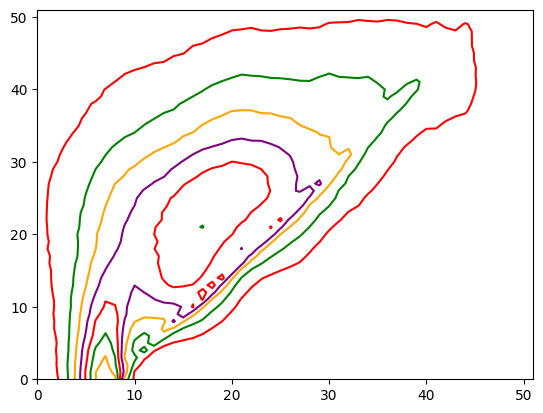

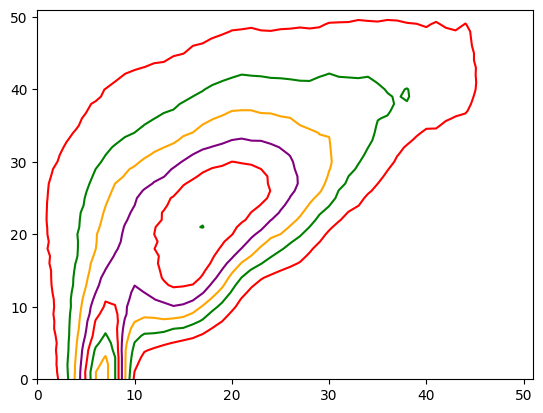

In [15]:
df=croprange(df,315)
plt.figure()
CF_pre=plt.contour(df, colors=['red', 'green', 'orange', 'purple'], extend='both')
unscatter(df,0,1,10,True)
unscatter(df,0,2,10,True)
unscatter(df,1,2,10,True)
plt.figure()
CP_post=plt.contour(df, colors=['red', 'green', 'orange', 'purple'], extend='both')